In [5]:
# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [6]:
from IPython.display import Image
%matplotlib inline

In [7]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [8]:
# 1: Streamlining workflows with pipelines

# Loading the Breast Cancer Wisconsin dataset
import pandas as pd
import urllib

try:
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)
except urllib.error.URLError:
    df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book/master/code/'
                     'datasets/wdbc/wdbc.data', header=None)
print('rows, columns:', df.shape)
df.head()

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
from sklearn.preprocessing import LabelEncoder

X, y = df.iloc[:, 2:].values, df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=0.20, random_state=1)

In [11]:
# Combining transformers and estimators in a pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accurcay: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accurcay: 0.947


In [12]:
# 2:Using k-fold cross validation to assess model performance

# 用K-折叠交叉验证法评估模型性能

import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Accuracy: %.3f' % (k+1,
            np.bincount(y_train[train]),score))
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Accuracy: 0.891
Fold: 2, Class dist.: [256 153], Accuracy: 0.978
Fold: 3, Class dist.: [256 153], Accuracy: 0.978
Fold: 4, Class dist.: [256 153], Accuracy: 0.913
Fold: 5, Class dist.: [256 153], Accuracy: 0.935
Fold: 6, Class dist.: [257 153], Accuracy: 0.978
Fold: 7, Class dist.: [257 153], Accuracy: 0.933
Fold: 8, Class dist.: [257 153], Accuracy: 0.956
Fold: 9, Class dist.: [257 153], Accuracy: 0.978
Fold: 10, Class dist.: [257 153], Accuracy: 0.956

CV accuracy: 0.950 +/- 0.029


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]

CV accuracy: 0.950 +/- 0.029


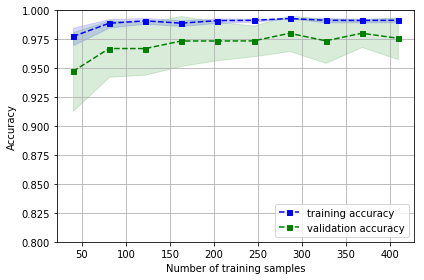

In [14]:
# 3:Debugging algorithms with learning curves

# Diagnosing bias and variance problems with learning curves
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X = X_train,
                               y = y_train,
                               train_sizes = np.linspace(0.1, 1.0, 10),
                               cv = 10,
                               n_jobs = 1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', linestyle='--',
         marker='s', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

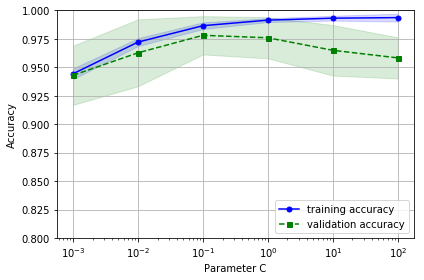

In [16]:
# Addressing over- and underfitting with validation curves
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='clf__C',
                param_range=param_range,
                cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

In [20]:
# Fine-tuning machine learning models via grid search

# Tuning hyperparameters via grid search
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__gamma': param_range,
              'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [22]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [24]:
# Looking at different performance evaluation metrics

# Reading a confusion matrix

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


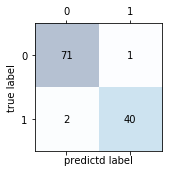

In [26]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predictd label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

In [27]:
# Additional Note

# Remember that we previously encoded the class labels 
# so that malignant samples are the "postive" class (1), 
# and benign samples are the "negative" class (0):
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [28]:
# Next, we printed the confusion matrix like so:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [32]:
# Note that the (true) class 0 samples that are correctly predicted 
# as class 0 (true negatives) are now in the upper left corner of 
# the matrix (index 0, 0). In order to change the ordering so that 
# the true negatives are in the lower right corner (index 1,1) 
# and the true positves are in the upper left, 
# we can use the labels argument like shown below:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


In [33]:
# We conclude:
# Assuming that class 1 (malignant) is the positive class in this example,
# our model correctly classified 71 of the samples that belong to class 0 (true negatives)
# and 40 samples that belong to class 1 (true positives),respectively.
# However, our model also incorrectly misclassified 1 sample from class 0 as class 1 (false positive),
# and it predicted that 2 samples are benign although it is a malignant tumor (false negatives).

In [35]:
# Optimizing the precision and recall of a classification model

from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [37]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9827986682076318
{'clf__C': 0.1, 'clf__kernel': 'linear'}
